# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Look at the data

In [30]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
print("Number of records in 'portfolio' : {}".format(portfolio.shape[0]))
print("Number of records in 'profile'   : {}".format(profile.shape[0]))
print("Number of records in 'transcript': {}".format(transcript.shape[0]))

eventTypes = {
    "transaction": transcript.loc[transcript['event']=='transaction'].shape[0],
    "offer received": transcript.loc[transcript['event']=='offer received'].shape[0],
    "offer viewed": transcript.loc[transcript['event']=='offer viewed'].shape[0],
    "offer completed": transcript.loc[transcript['event']=='offer completed'].shape[0]
}
print(eventTypes)

profile.loc[profile['gender']=='M'].shape

genders = {
    "M": profile.loc[profile['gender']=='M'].shape[0],
    "F": profile.loc[profile['gender']=='F'].shape[0],
    "O": profile.loc[profile['gender']=='O'].shape[0],
}
genders["None"] = profile.shape[0] - genders['M'] - genders['F'] - genders['O']
print(genders)

Number of records in 'portfolio' : 10
Number of records in 'profile'   : 17000
Number of records in 'transcript': 306534
{'transaction': 138953, 'offer received': 76277, 'offer viewed': 57725, 'offer completed': 33579}
{'M': 8484, 'F': 6129, 'O': 212, 'None': 2175}


# 1 - Data Cleaning and Preparation

## 1.1: Cleaning provided tables

### (1.1.a) Process the Offers table "portfolio"

In [6]:
# Change duration column from days to hours
portfolio['duration'] = portfolio['duration'].apply(lambda x: x*24)

# Add a new easy-to-read key for the table
portfolio['id_new'] = portfolio.index
portfolio['id_new'] = portfolio['id_new'].apply(lambda x: 'offer_' + str(x))

# One-hot encoding of channels. Ignore email since it's always used.
portfolio['web'] = portfolio['channels'].apply(lambda l: 1 if 'web' in l else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda l: 1 if 'mobile' in l else 0)
portfolio['social'] = portfolio['channels'].apply(lambda l: 1 if 'social' in l else 0)

# Drop the original channels column
portfolio = portfolio.drop(['channels'], axis=1)

# Add one offer record that represents no offer
#portfolio = portfolio.append(pd.Series([], index=portfolio.columns), ignore_index=True)

portfolio.head(11)

,difficulty,duration,id,offer_type,reward,id_new,web,mobile,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer_0,0,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,offer_1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,offer_2,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,offer_3,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer_4,1,0,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,offer_5,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,offer_6,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,offer_7,0,1,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,offer_8,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,offer_9,1,1,0


### (1.1.b) Process the Profile table "profile"

In [7]:
# Drop profiles with missing gender + income
profile = profile.loc[profile['gender'].notnull()]

# Replace membership length with number of years since membership started
# Assume 2018 is 0 years, 2017 is 1 years, etc.
profile['membership_years'] = profile['became_member_on'].apply(lambda x: str(x)[:4])
profile['membership_years'] = profile['membership_years'].apply(lambda x: 2018-int(x))
profile = profile.drop(['became_member_on'], axis=1)

# Preview data
profile.head()

,age,gender,id,income,membership_years
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1


### (1.1.c) Process the Transactions table "transcript"

In [8]:
# Unfold "value" dictionary
def getColumnName(dic, cols):
    for col in cols:
        if col in dic.keys():
            return dic[col]
    return ''

transcript['offer_id'] = transcript['value'].apply(lambda d: getColumnName(d, ['offer id','offer_id']))
transcript['rewarded'] = transcript['value'].apply(lambda d: d['reward'] if 'reward' in d.keys() else None)
transcript['amount'] = transcript['value'].apply(lambda d: round(d['amount']) if 'amount' in d.keys() else None)
transcript = transcript.drop(['value'], axis=1)

# Join the "transcript" table with "portfolio" table
transcript = pd.merge(transcript, portfolio, left_on='offer_id', right_on='id', how='outer').drop(['offer_id','id'], axis=1)
transcript = transcript.rename(columns={"id_new":"offer_id"})

# Sort the table by person/time
transcript = transcript.sort_values(['person','time']).reset_index(drop=True)

transcript.head(10)

,event,person,time,rewarded,amount,difficulty,duration,offer_type,reward,offer_id,web,mobile,social
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,0.0,72.0,informational,0.0,offer_7,0.0,1.0,1.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,0.0,72.0,informational,0.0,offer_7,0.0,1.0,1.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,0.0,96.0,informational,0.0,offer_2,1.0,1.0,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,0.0,96.0,informational,0.0,offer_2,1.0,1.0,0.0
5,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,5.0,120.0,bogo,5.0,offer_8,1.0,1.0,1.0
6,offer completed,0009655768c64bdeb2e877511632db8f,414,5.0,NaN,5.0,120.0,bogo,5.0,offer_8,1.0,1.0,1.0
7,transaction,0009655768c64bdeb2e877511632db8f,414,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,5.0,120.0,bogo,5.0,offer_8,1.0,1.0,1.0
9,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,10.0,240.0,discount,2.0,offer_6,1.0,1.0,1.0


## 1.2: Preparing clean dataset

### (1.2.a) Split transacript into (offers received and viewed log) and (transactions history)

#### Records log

In [9]:
# Get offer-related rows only
offers_cols = ['event','person','time','offer_id','duration']
offers_df = transcript[(transcript['event']=="offer received") | (transcript['event']=="offer viewed")][offers_cols]
offers_df = offers_df.sort_values(['person','offer_id','time']).reset_index(drop=True)

# Add a "valid_until" column for each offer to represent the point in time an offer's influence ends
offers_df['valid'] = offers_df['time'] + offers_df['duration']
offers_df['valid_shift'] = offers_df.groupby(['person','offer_id'])['valid'].shift(1)
offers_df['valid_until'] = offers_df[['valid','valid_shift']].min(axis=1)
offers_df = offers_df.drop(['valid','valid_shift'], axis=1)

# Preview data
#offers_df.head(10)
offers_df.loc[offers_df['person']=='ffff82501cea40309d5fdd7edcca4a07']

,event,person,time,offer_id,duration,valid_until
133990,offer received,ffff82501cea40309d5fdd7edcca4a07,504,offer_3,168.0,672.0
133991,offer viewed,ffff82501cea40309d5fdd7edcca4a07,534,offer_3,168.0,672.0
133992,offer received,ffff82501cea40309d5fdd7edcca4a07,168,offer_4,240.0,408.0
133993,offer viewed,ffff82501cea40309d5fdd7edcca4a07,174,offer_4,240.0,408.0
133994,offer received,ffff82501cea40309d5fdd7edcca4a07,0,offer_6,240.0,240.0
133995,offer viewed,ffff82501cea40309d5fdd7edcca4a07,6,offer_6,240.0,240.0
133996,offer received,ffff82501cea40309d5fdd7edcca4a07,336,offer_9,168.0,504.0
133997,offer viewed,ffff82501cea40309d5fdd7edcca4a07,354,offer_9,168.0,504.0
133998,offer received,ffff82501cea40309d5fdd7edcca4a07,408,offer_9,168.0,522.0
133999,offer viewed,ffff82501cea40309d5fdd7edcca4a07,414,offer_9,168.0,576.0


In [10]:
# Get only rows where the offer was viewed
offer_viewed_df = offers_df.loc[offers_df['event']=="offer viewed"]

# Preview the data
offer_viewed_df.head(10)
#offer_viewed_df.loc[offer_viewed_df['person']=='ffff82501cea40309d5fdd7edcca4a07']

,event,person,time,offer_id,duration,valid_until
1,offer viewed,0009655768c64bdeb2e877511632db8f,372,offer_2,96.0,432.0
3,offer viewed,0009655768c64bdeb2e877511632db8f,540,offer_6,240.0,744.0
5,offer viewed,0009655768c64bdeb2e877511632db8f,192,offer_7,72.0,240.0
7,offer viewed,0009655768c64bdeb2e877511632db8f,456,offer_8,120.0,528.0
10,offer viewed,00116118485d4dfda04fdbaba9a87b5c,216,offer_8,120.0,288.0
12,offer viewed,00116118485d4dfda04fdbaba9a87b5c,630,offer_8,120.0,696.0
14,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,6,offer_2,96.0,96.0
16,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,516,offer_3,168.0,672.0
18,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,432,offer_4,240.0,648.0
20,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,186,offer_5,168.0,336.0


In [11]:
# Get transaction rows only
transactions_cols = ['event','person','time','amount']
transactions_df = transcript.loc[transcript['event']=="transaction"][transactions_cols]

# Add a transaction id as a key to identify transactions for deduplication later
transactions_df['trans_id'] = transactions_df.index

# Preview data
transactions_df.head()

,event,person,time,amount,trans_id
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.0,2
7,transaction,0009655768c64bdeb2e877511632db8f,414,9.0,7
11,transaction,0009655768c64bdeb2e877511632db8f,528,14.0,11
13,transaction,0009655768c64bdeb2e877511632db8f,552,14.0,13
16,transaction,0009655768c64bdeb2e877511632db8f,576,10.0,16


### (1.2.b) Merge Offers Viewed & Transactions, and find influenced transactions

In [12]:
# Merge the offers_viewed and transactions tables for each person
offer_trans_df = pd.merge(offer_viewed_df, transactions_df, on='person', how='outer')

# Mark records where the transaction was influenced by the offer viewed; happens when:
# Valid_until(offer) >= Time(transaction) >= Time(Offer viewed)
offer_trans_df['offer_influenced'] = 0
offer_trans_df.loc[(offer_trans_df['time_y']>=offer_trans_df['time_x']) & \
                   (offer_trans_df['time_y']<offer_trans_df['valid_until']), 'offer_influenced'] = 1

# Keep only the records of transactions influenced by an offer
offer_trans_df = offer_trans_df.loc[offer_trans_df['offer_influenced']==1]

# Preview data
offer_trans_df.loc[offer_trans_df['trans_id']==306522.0] #42  #306526.0  #306533.0
#offer_trans_df

,event_x,person,time_x,offer_id,duration,valid_until,event_y,time_y,amount,trans_id,offer_influenced
495042,offer viewed,ffff82501cea40309d5fdd7edcca4a07,354.0,offer_9,168.0,504.0,transaction,414.0,18.0,306522.0,1
495057,offer viewed,ffff82501cea40309d5fdd7edcca4a07,414.0,offer_9,168.0,576.0,transaction,414.0,18.0,306522.0,1


### (1.2.c) Aggregate amount per (person, offer influenced) combination

In [13]:
# Deduplicate all (person, offer, transaction) tuples
# This is to avoid instances of the same transactions beonging to the same offer more than once
# This could happen if the offer was sent twice, with 2 overlapping time periods, and a transactions belongs to both instances
df = offer_trans_df[['person','offer_id','trans_id','amount']]
df = df.groupby(['person','offer_id','trans_id']).agg(['max']).reset_index(inplace=False).drop(['trans_id'], axis=1)

# Group by (person/offer) and sum the amount spent
df = df.groupby(['person','offer_id']).agg('sum').reset_index(inplace=False)
df.columns = ['person','offer_id','amount']

df.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


(37431, 3)

In [14]:
# Merge with profile and portfolio tanles to obtain potential model features
df_final = pd.merge(df, profile, left_on='person', right_on='id', how='inner').drop(['id'], axis=1)
df_final = pd.merge(df_final, portfolio, left_on='offer_id', right_on='id_new', how='inner').drop(['id','id_new'], axis=1)
df_final = df_final.sort_values(['person','offer_id']).reset_index(drop=True)

# Preview data
df_final.head(10)

,person,offer_id,amount,age,gender,income,membership_years,difficulty,duration,offer_type,reward,web,mobile,social
0,0009655768c64bdeb2e877511632db8f,offer_2,9.0,33,M,72000.0,1,0,96,informational,0,1,1,0
1,0009655768c64bdeb2e877511632db8f,offer_6,82.0,33,M,72000.0,1,10,240,discount,2,1,1,1
2,0009655768c64bdeb2e877511632db8f,offer_7,22.0,33,M,72000.0,1,0,72,informational,0,0,1,1
3,0011e0d4e6b944f998e987f904e8c1e5,offer_3,54.0,40,O,57000.0,0,5,168,bogo,5,1,1,0
4,0011e0d4e6b944f998e987f904e8c1e5,offer_4,45.0,40,O,57000.0,0,20,240,discount,5,1,0,0
5,0011e0d4e6b944f998e987f904e8c1e5,offer_5,12.0,40,O,57000.0,0,7,168,discount,3,1,1,1
6,0020c2b971eb4e9188eac86d93036a77,offer_1,17.0,59,F,90000.0,2,10,120,bogo,10,1,1,1
7,0020c2b971eb4e9188eac86d93036a77,offer_6,98.0,59,F,90000.0,2,10,240,discount,2,1,1,1
8,0020ccbbb6d84e358d3414a3ff76cffd,offer_3,10.0,24,F,60000.0,2,5,168,bogo,5,1,1,0
9,0020ccbbb6d84e358d3414a3ff76cffd,offer_5,47.0,24,F,60000.0,2,7,168,discount,3,1,1,1


## 1.3: Further Data Analysis

{'Male': 8.58015087223008, 'Female': 8.057105563713494}


Text(0, 0.5, 'Avg. # of transactions per customer')

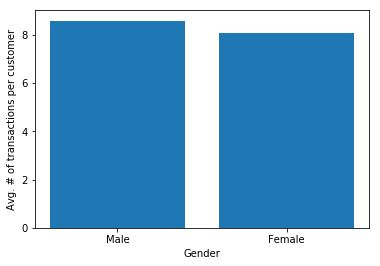

In [48]:
transactions_df_2 = pd.merge(transactions_df, profile, how='inner', left_on='person', right_on='id').drop(['id'], axis=1)
transactions_df_2 = transactions_df_2.loc[transactions_df_2['gender'].notnull()]

trans_count_male = transactions_df_2.loc[transactions_df_2['gender']=='M']['gender'].count()
trans_count_female = transactions_df_2.loc[transactions_df_2['gender']=='F']['gender'].count()

male_customer_count = profile.loc[profile['gender']=='M']['id'].count()
female_customer_count = profile.loc[profile['gender']=='F']['id'].count()

transaction_count_per_customer = {
    'Male': trans_count_male / male_customer_count,
    'Female': trans_count_female / female_customer_count
}

print(transaction_count_per_customer)

xlabels = ['Male', 'Female']
yvalues = list(transaction_count_per_customer.values())
plt.bar(xlabels, yvalues)
plt.xlabel('Gender')
plt.ylabel('Avg. # of transactions per customer')

#print(trans_count_male)
#print(male_customer_count)
#print(trans_count_female)
#print(female_customer_count)

In [15]:
total_sales_influenced_by_offers = df_final['amount'].sum()
print("Total Offer-Influenced Sales = {}".format(total_sales_influenced_by_offers))

total_sales = transcript.loc[transcript['amount'].notnull()]['amount'].sum()
print("Total Sales                  = {}".format(total_sales))

offer_influenced_sales_ratio = total_sales_influenced_by_offers / total_sales
print("Percentage of sales influenced by offers: {}".format(offer_influenced_sales_ratio))

Total Offer-Influenced Sales = 1472650.0
Total Sales                  = 1774898.0
Percentage of sales influenced by offers: 0.8297096509207853


Text(0.5, 0, 'Sales')

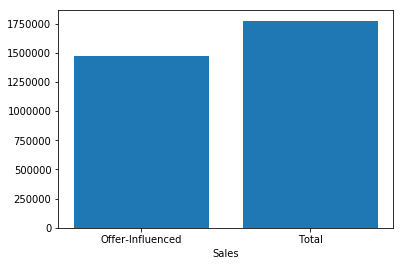

In [37]:
xlabels = ['Offer-Influenced','Total']
yvalues = [total_sales_influenced_by_offers, total_sales]

plt.bar(xlabels, yvalues)
plt.xlabel('Sales')

In [27]:
total_offer_durations = {
    'total_duration_bogo': portfolio.loc[portfolio['offer_type']=='bogo']['duration'].sum() / 24,
    'total_duration_discount': portfolio.loc[portfolio['offer_type']=='discount']['duration'].sum() / 24,
    'total_duration_informational': portfolio.loc[portfolio['offer_type']=='informational']['duration'].sum() / 24
}
print('Total duration per offer type: {}'.format(total_offer_durations))

sales_per_offer = {
    'sales_per_offer_bogo' : df_final.loc[df_final['offer_type']=='bogo']['amount'].sum() / total_offer_durations['total_duration_bogo'],
    'sales_per_offer_discount' : df_final.loc[df_final['offer_type']=='discount']['amount'].sum() / total_offer_durations['total_duration_discount'],
    'sales_per_offer_informational' : df_final.loc[df_final['offer_type']=='informational']['amount'].sum() / total_offer_durations['total_duration_informational']
}
print("Sales per offer type per day: {}".format(sales_per_offer))


Total duration per offer type: {'total_duration_bogo': 24.0, 'total_duration_discount': 34.0, 'total_duration_informational': 7.0}
Sales per offer type per day: {'sales_per_offer_bogo': 25345.833333333332, 'sales_per_offer_discount': 21902.970588235294, 'sales_per_offer_informational': 17092.714285714286}


Text(0.5, 0, 'Sales per offer instance per day')

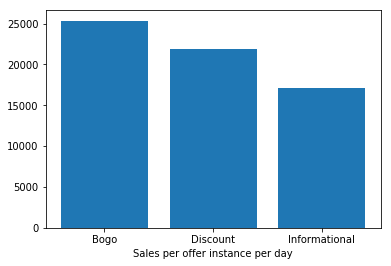

In [32]:
#xlabels = [k for k in sales_per_offer.keys()]
xlabels = ['Bogo', 'Discount', 'Informational']
yvalues = list(sales_per_offer.values())

plt.bar(xlabels, yvalues)
plt.xlabel('Sales per offer instance per day')

# 2 - Preparing dataset for modeling

## 2.1: Feature Selection

### (2.1.a) Transform categorical columns into multiple binary columns

In [17]:
df = df_final

# Transform the gender categorical column (values: 'M','F','O') to 2 binary columns ('male', 'female')
df['male'] = df['gender'].apply(lambda x: 1 if x=='M' else 0)
df['female'] = df['gender'].apply(lambda x: 1 if x=='F' else 0)
df = df.drop(['gender'], axis=1)

# Transform the offer_type categorical column (values: 'bogo','discount','informational') to 2 binary columns ('bogo', 'discount')
df['bogo'] = df['offer_type'].apply(lambda x: 1 if x=='bogo' else 0)
df['discount'] = df['offer_type'].apply(lambda x: 1 if x=='discount' else 0)
df = df.drop(['offer_type'], axis=1)

df.head()

,person,offer_id,amount,age,income,membership_years,difficulty,duration,reward,web,mobile,social,male,female,bogo,discount
0,0009655768c64bdeb2e877511632db8f,offer_2,9.0,33,72000.0,1,0,96,0,1,1,0,1,0,0,0
1,0009655768c64bdeb2e877511632db8f,offer_6,82.0,33,72000.0,1,10,240,2,1,1,1,1,0,0,1
2,0009655768c64bdeb2e877511632db8f,offer_7,22.0,33,72000.0,1,0,72,0,0,1,1,1,0,0,0
3,0011e0d4e6b944f998e987f904e8c1e5,offer_3,54.0,40,57000.0,0,5,168,5,1,1,0,0,0,1,0
4,0011e0d4e6b944f998e987f904e8c1e5,offer_4,45.0,40,57000.0,0,20,240,5,1,0,0,0,0,0,1


### (2.1.b) Select feature columns for model input

In [18]:
#df = df.drop(['person','offer_id','difficulty','reward','web','mobile','social'], axis=1)
df = df.drop(['person','offer_id','web','mobile','social'], axis=1)

## 2.2: Create final data files

### (2.2.a) Train-test split

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop(['amount'], axis=1)
y = df['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

### (2.2.b) Transform data using Standard Scaler (standardization)

In [20]:
from sklearn.preprocessing import StandardScaler, Normalizer

scaler = StandardScaler()
#scaler = Normalizer()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

#X_train = pd.DataFrame(X_train, columns=X.columns)
#X_valid = pd.DataFrame(X_valid, columns=X.columns)
#X_test = pd.DataFrame(X_test, columns=X.columns)

# Use code below if using StandardScaler
y_train = y_train.to_numpy('float32')
y_valid = y_valid.to_numpy('float32')
y_test = y_test.to_numpy('float32')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/env

### (2.2.c) Save CSV files locally

In [21]:
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # create dataframe with labels in the first column and upload it to csv
    df = pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1)
    df.to_csv(os.path.join(data_dir, filename), header=False, index=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [22]:
import os

data_dir = 'starbucks_data'

make_csv(X_train, y_train, filename='train.csv', data_dir=data_dir)
make_csv(X_valid, y_valid, filename='valid.csv', data_dir=data_dir)
make_csv(X_test, y_test, filename='test.csv', data_dir=data_dir)

Path created: starbucks_data/train.csv
Path created: starbucks_data/valid.csv
Path created: starbucks_data/test.csv


In [53]:
X_train.shape

(21020, 10)

In [54]:
X_valid.shape

(5256, 10)

In [55]:
X_test.shape

(6569, 10)

# END